In [129]:
import csv
from collections import Counter, defaultdict
from tqdm import tqdm
import json
import numpy as np
import gzip
from datetime import datetime
from sentence_transformers import SentenceTransformer
import os
import re
import joblib
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# your modules are imported here
from indexing import Indexer, BasicInvertedIndex
from document_preprocessor import RegexTokenizer, Doc2QueryAugmenter
from ranker import Ranker, BM25, CrossEncoderScorer
from vector_ranker import VectorRanker
from l2r import L2RFeatureExtractor, L2RRanker
from vectordb_ranker import VectorDBRanker

In [34]:
from importlib import reload
import indexing
reload(indexing)
from indexing import Indexer
import document_preprocessor
reload(document_preprocessor)
from document_preprocessor import RegexTokenizer, Doc2QueryAugmenter
import l2r
reload(l2r)
from l2r import L2RFeatureExtractor, L2RRanker

In [35]:
data_prefix = '../data/'
model_prefix = '../models/'

In [4]:
with open(data_prefix + 'rec_cats.json', 'r') as f:
    rec_cats = json.load(f)
    five_cats = rec_cats['short']
    all_cats = rec_cats['full']
with open(data_prefix + 'doc_cat_info.json', 'r') as f:
    doc_cat_info = json.load(f)
    doc_cat_info = {int(k):v for k, v in doc_cat_info.items()}

In [5]:
# with open('../interior_dic.json', 'r') as f:
#     query_alts_rels = json.load(f)
#     queries = list(query_alts_rels.keys())
#     for query in queries:
#         del query_alts_rels[query]['alt_qs'][5]
#         for i in range(5):
#             q = query_alts_rels[query]['alt_qs'][i]
#             query_alts_rels[query]['alt_qs'][i] = q[3:]
#         query_alts_rels[query]['scored_docs'] = [(l[0], l[1]) for l in query_alts_rels[query]['scored_docs']]
#     train_queries = queries[:41]
#     test_queries = queries[41:]
# with open('../train_data.json', 'w') as f:
#     train_data = {query: query_alts_rels[query] for query in train_queries}
#     test_data = {query: query_alts_rels[query] for query in test_queries}
#     json.dump(train_data, f, indent=2)
# with open('../test_data.json', 'w') as f:
#     json.dump(test_data, f, indent=2)


In [6]:
# aug1 = Doc2QueryAugmenter()
# aug2 = Doc2QueryAugmenter('doc2query/msmarco-t5-small-v1')
# aug3 = Doc2QueryAugmenter('google/flan-t5-small')
# prefix = "Generate a query for the following text: "

In [7]:
# with open('../final_data_with_categories.json', 'r') as f:
#     lines = f.readlines()
#     docs = []
#     for line in tqdm(lines):
#         doc = json.loads(line)
#         doc['alt_qs'] = aug1.get_queries(doc['text'], 5)
#         doc['dumb_qs_1'] = aug2.get_queries(doc['text'], 5)
#         doc['dumb_qs_2'] = aug3.get_queries(doc['text'], 5, prefix)
#         docs.append(doc)
# with open('../data/doc_dataset.jsonl', 'a') as f:
#     for doc in docs:
#         f.write(json.dumps(doc) + '\n')

In [8]:
# with open('../data/doc_dataset_old.jsonl', 'r') as f:
#     line = f.readline()
#     doc_inds = [m.start() for m in re.finditer('{"docid":', line)]
#     docs = []
#     for i in range(len(doc_inds)):
#         start = doc_inds[i]
#         end = len(line) if i == len(doc_inds) - 1 else doc_inds[i + 1]
#         doc_text = line[start:end]
#         doc = json.loads(doc_text)
#         docs.append(doc)

In [9]:
# with open('../data/doc_dataset.jsonl', 'a') as f:
#     for doc in docs:
#         f.write(json.dumps(doc) + '\n')

In [10]:
doc_preproc = RegexTokenizer('\\w+')
stopwords = set()
with open(data_prefix + 'stopwords.txt', 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 543'

In [11]:
# doc_base_index = Indexer.create_index(data_prefix + 'doc_dataset.jsonl', doc_preproc, stopwords, 'text', 'alt_qs', data_prefix + 'doc_base_index')

In [12]:
doc_base_index = BasicInvertedIndex()
doc_base_index.load(data_prefix + 'doc_base_index')
doc_small_index = BasicInvertedIndex()
doc_small_index.load(data_prefix + 'doc_small_index')
doc_flan_index = BasicInvertedIndex()
doc_flan_index.load(data_prefix + 'doc_flan_index')
doc_index = BasicInvertedIndex()
doc_index.load(data_prefix + 'doc_index')
tit_index = BasicInvertedIndex()
tit_index.load(data_prefix + 'title_index')

In [13]:
# doc_small_index = Indexer.create_index(data_prefix + 'doc_dataset.jsonl', doc_preproc, stopwords, 'text', 'dumb_qs_1', data_prefix + 'doc_small_index')
# doc_flan_index = Indexer.create_index(data_prefix + 'doc_dataset.jsonl', doc_preproc, stopwords, 'text', 'dumb_qs_2', data_prefix + 'doc_flan_index')
# doc_index = Indexer.create_index(data_prefix + 'doc_dataset.jsonl', doc_preproc, stopwords, 'text', '', data_prefix + 'doc_index')
# tit_index = Indexer.create_index(data_prefix + 'doc_dataset.jsonl', doc_preproc, stopwords, 'title', '', data_prefix + 'title_index')


In [14]:
def query_runner(ranker, queries):
    scores = [ranker.query(query) for query in queries]
    final_scores = []
    docids = [dic['docid'] for dic in scores[0]]
    for doc in docids:
        cum_score = 0
        for score_l in scores:
            for dic in score_l:
                if dic['docid'] == doc:
                    cum_score += dic['score']
                    break
        final_scores.append({'docid': doc, 'score': cum_score / len(queries)})
    return final_scores

In [15]:
with open(data_prefix + 'raw_text.json', 'r') as f:
    raw_text_dict = json.load(f)
    raw_text_dict = {int(k):v for k, v in raw_text_dict.items()}
with open(data_prefix + 'base_raw_text.json', 'r') as f:
    base_raw_text_dict = json.load(f)
    base_raw_text_dict = {int(k):v for k, v in base_raw_text_dict.items()}
with open(data_prefix + 'small_raw_text.json', 'r') as f:
    small_raw_text_dict = json.load(f)
    small_raw_text_dict = {int(k):v for k, v in small_raw_text_dict.items()}
with open(data_prefix + 'flan_raw_text.json', 'r') as f:
    flan_raw_text_dict = json.load(f)
    flan_raw_text_dict = {int(k):v for k, v in flan_raw_text_dict.items()}

In [16]:
ce_scorer = CrossEncoderScorer(raw_text_dict)
bce_scorer = CrossEncoderScorer(base_raw_text_dict)
sce_scorer = CrossEncoderScorer(small_raw_text_dict)
fce_scorer = CrossEncoderScorer(flan_raw_text_dict)

In [17]:
nn_feat_extract = L2RFeatureExtractor(doc_index, tit_index, doc_cat_info, doc_preproc, stopword, set(), ce_scorer)
nf_feat_extract = L2RFeatureExtractor(doc_index, tit_index, doc_cat_info, doc_preproc, stopword, set(five_cats), ce_scorer)
na_feat_extract = L2RFeatureExtractor(doc_index, tit_index, doc_cat_info, doc_preproc, stopword, set(all_cats), ce_scorer)
bf_feat_extract = L2RFeatureExtractor(doc_base_index, tit_index, doc_cat_info, doc_preproc, stopword, set(five_cats), bce_scorer)
sf_feat_extract = L2RFeatureExtractor(doc_small_index, tit_index, doc_cat_info, doc_preproc, stopword, set(five_cats), sce_scorer)
ff_feat_extract = L2RFeatureExtractor(doc_flan_index, tit_index, doc_cat_info, doc_preproc, stopword, set(five_cats), fce_scorer)
ba_feat_extract = L2RFeatureExtractor(doc_base_index, tit_index, doc_cat_info, doc_preproc, stopword, set(all_cats), bce_scorer)

In [4]:
nn_model = joblib.load(model_prefix + 'nn_model.joblib')
nf_model = joblib.load(model_prefix + 'nf_model.joblib')
na_model = joblib.load(model_prefix + 'na_model.joblib')
bf_model = joblib.load(model_prefix + 'bf_model.joblib')
sf_model = joblib.load(model_prefix + 'sf_model.joblib')
ff_model = joblib.load(model_prefix + 'ff_model.joblib')
ba_model = joblib.load(model_prefix + 'ba_model.joblib')

: 

In [21]:
with open(data_prefix + 'test_data.json', 'r') as f:
    test_data = json.load(f)
    test_queries = list(test_data.keys())

In [ ]:
bm25_ranker = BM25(doc_index)
vdb_ranker = VectorDBRanker(raw_text_dict)
bvdb_ranker = VectorDBRanker(base_raw_text_dict)
svdb_ranker = VectorDBRanker(small_raw_text_dict)
fvdb_ranker = VectorDBRanker(flan_raw_text_dict)

In [ ]:
bm25_nq_nn_ranker = L2RRanker(doc_index, tit_index, doc_preproc, stopword, bm25_ranker, nn_feat_extract)
bm25_nq_nn_ranker.model.lgbmranker = nn_model
bm25_nq_nn_scores = [bm25_nq_nn_ranker.query(query) for query in test_queries]

In [ ]:
bm25_nq_nf_ranker = L2RRanker(doc_index, tit_index, doc_preproc, stopword, bm25_ranker, nf_feat_extract)
bm25_nq_nf_ranker.model.lgbmranker = nf_model
bm25_nq_nf_scores = [bm25_nq_nf_ranker.query(query) for query in test_queries]

In [ ]:
bienc_nq_nn_ranker = L2RRanker(doc_index, tit_index, doc_preproc, stopword, vdb_ranker, nn_feat_extract)
bienc_nq_nn_ranker.model.lgbmranker = nn_model
bienc_nq_nn_scores = [bm25_nq_nn_ranker.query(query) for query in test_queries]

In [ ]:
bienc_nq_na_ranker = L2RRanker(doc_index, tit_index, doc_preproc, stopword, vdb_ranker, na_feat_extract)
bienc_nq_na_ranker.model.lgbmranker = na_model
bienc_nq_na_scores = [bienc_nq_na_ranker.query(query) for query in test_queries]

In [ ]:
bienc_nq_nf_ranker = L2RRanker(doc_index, tit_index, doc_preproc, stopword, vdb_ranker, nf_feat_extract)
bienc_nq_nf_ranker.model.lgbmranker = nf_model
bienc_nq_nf_scores = [bienc_nq_nf_ranker.query(query) for query in test_queries]

In [ ]:
bienc_tq_nf_ranker = L2RRanker(doc_index, tit_index, doc_preproc, stopword, vdb_ranker, nf_feat_extract)
bienc_tq_nf_ranker.model.lgbmranker = nf_model
bienc_tq_nf_scores = [query_runner(bienc_tq_nf_ranker, [query, test_data[query]['alt_qs'][-1]]) for query in test_queries]

In [ ]:
bienc_sq_nf_ranker = L2RRanker(doc_index, tit_index, doc_preproc, stopword, vdb_ranker, nf_feat_extract)
bienc_sq_nf_ranker.model.lgbmranker = nf_model
bienc_sq_nf_scores = [query_runner(bienc_sq_nf_ranker, [query] + test_data[query]['alt_qs'][:5]) for query in test_queries]

In [ ]:
bienc_aq_nf_ranker = L2RRanker(doc_index, tit_index, doc_preproc, stopword, vdb_ranker, nf_feat_extract)
bienc_aq_nf_ranker.model.lgbmranker = nf_model
bienc_aq_nf_scores = [query_runner(bienc_aq_nf_ranker, [query] + test_data[query]['alt_qs']) for query in test_queries]

In [ ]:
bienc_nq_bf_ranker = L2RRanker(doc_base_index, tit_index, doc_preproc, stopword, bvdb_ranker, bf_feat_extract)
bienc_nq_bf_ranker.model.lgbmranker = bf_model
bienc_nq_bf_scores = [bienc_nq_bf_ranker.query(query) for query in test_queries]

In [ ]:
bienc_nq_sf_ranker = L2RRanker(doc_small_index, tit_index, doc_preproc, stopword, svdb_ranker, sf_feat_extract)
bienc_nq_sf_ranker.model.lgbmranker = sf_model
bienc_nq_sf_scores = [bienc_nq_sf_ranker.query(query) for query in test_queries]

In [ ]:
bienc_nq_ff_ranker = L2RRanker(doc_flan_index, tit_index, doc_preproc, stopword, fvdb_ranker, ff_feat_extract)
bienc_nq_ff_ranker.model.lgbmranker = ff_model
bienc_nq_ff_scores = [bienc_nq_ff_ranker.query(query) for query in test_queries]

In [ ]:
bienc_aq_ba_ranker = L2RRanker(doc_base_index, tit_index, doc_preproc, stopword, bvdb_ranker, ba_feat_extract)
bienc_aq_ba_ranker.model.lgbmranker = ba_model
bienc_aq_ba_scores = [query_runner(bienc_aq_ba_ranker, [query] + test_data[query]['alt_qs']) for query in test_queries]

In [ ]:
from sklearn.metrics import ndcg_score
true_relevance = np.array([[20, 0, 0, 1, 5]])
scores = np.array([[-10, -100, -100, -15, -12]])
ndcg_score(true_relevance, scores)

In [22]:
print(test_data.keys())

dict_keys(['What are the symptoms of a rash on the hands?', 'what do we need to know before attelectasis is diagnosed?', 'How do you know if you have a popliteal artery aneurysm?', 'what are the symptoms of pediatric sleep apnea?', 'what is the common sign of spinal stenosis', 'who has a broken nose?', 'Which syndrome is known as triple X syndrome?', 'What are the symptoms of chronic hives?', 'What is the typical time span for the development of symptoms of epiglottitis?', 'What are the symptoms of long term exposure to asbestos?', 'What can increase the pain?', 'Who does the word "abuser" refer to?', 'How can you tell if you are albinic?', 'What are some symptoms of pediatric sleep apnea?', 'What is the first symptom that should be looked for in infants with reflux?', 'what are signs and symptoms of encopresis?', 'What is the most common sign of hydrocele?', 'what can cause blood in your urine?'])


In [23]:
print(test_data['What are the symptoms of a rash on the hands?']['scored_docs'])

[[374, 1], [742, 1], [647, 1], [547, 1], [186, 1], [66, 1], [668, 1], [699, 1], [281, 1], [587, 1], [943, 1], [1006, 1], [557, 1], [112, 1], [359, 1], [471, 1], [580, 1], [500, 1], [549, 2], [143, 1], [520, 1], [800, 1], [145, 1], [910, 1], [280, 1], [1050, 2], [478, 1], [21, 1], [522, 4], [1017, 1], [841, 1], [217, 1], [685, 1], [273, 4], [738, 1], [187, 1], [87, 1], [1030, 1], [698, 1], [308, 1], [405, 1], [533, 1], [794, 1], [770, 1], [990, 1], [667, 1], [475, 1], [80, 1], [346, 1], [378, 1]]


In [24]:
for query in test_data.keys():
    test_data[query]['scored_docs'] = {tup[0]:tup[1] for tup in test_data[query]['scored_docs']}

In [95]:
def run_rel(query, scores):
    if len(scores) == 0:
        return 0
    y_score = np.array([[tup[1] for tup in scores]])
    data = test_data[query]['scored_docs']
    y_true = np.array([[1 if tup[0] not in data.keys() else data[tup[0]] for tup in scores]])
    ndcg = metrics.ndcg_score(y_true, y_score, k=10)
    return ndcg

In [112]:
def run_rel(query, scores):
    if len(scores) == 0:
        return 0
    y_score = np.array([[dic['score'] for dic in scores]])
    data = test_data[query]['scored_docs']
    y_true = np.array([[1 if dic['docid'] not in data.keys() else data[dic['docid']] for dic in scores]])
    ndcg = metrics.ndcg_score(y_true, y_score, k=10)
    return ndcg

In [ ]:
def run_rel(query, scores):
    order = [tup[0] for tup in scores]
    data = test_data[query]
    act_scores = []
    for docid in order:
        if docid in data.keys():
            act_scores.append(data[docid])
        else:
            act_scores.append(1)
    id_scores = sorted(act_scores, reverse=True)
    map_inp = [1 if score > 3 else 0 for score in act_scores]
    ndcg = ndcg_score(act_scores, id_scores)
    return ndcg

In [113]:
all_scores = {}
with open(data_prefix + 'l2r_scores.json', 'r') as f:
    all_scores = json.load(f)

In [110]:
with open(data_prefix + 'scores_saved.json', 'r') as f:
    all_scores2 = json.load(f)

In [86]:
for k in all_scores2.keys():
    all_scores[k] = all_scores2[k]

In [111]:
models2 = list(all_scores2.keys())
model_ndcgs2 = []
for model in models2:
    scores = all_scores2[model]
    ndcgs = [run_rel(test_queries[i], scores[i]) for i in range(len(test_queries))]
    model_ndcgs2.append(ndcgs)

In [103]:
print(models2)
print(model_ndcgs2)

['bm25_native_scores', 'random_ranker_scores']
[0.43827031084946777, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6023097498746199, 1.0, 1.0, 0.3225181699807339, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.49523840430730154]


In [114]:
models = list(all_scores.keys())
model_ndcgs = []
for model in models:
    scores = all_scores[model]
    ndcgs = [run_rel(test_queries[i], scores[i]) for i in range(len(test_queries))]
    model_ndcgs.append(ndcgs)

In [115]:
big_models = models2 + models
big_model_ndcgs = model_ndcgs2 + model_ndcgs

In [116]:
df_data = []
for i in range(len(big_model_ndcgs)):
    l = big_model_ndcgs[i]
    for j in range(len(l)):
        row = [big_models[i], test_queries[j], l[j]]
        df_data.append(row)


In [119]:
model_ndcgs3 = model_ndcgs + model_ndcgs2
lst = []
for l in big_model_ndcgs:
    lst.append(np.mean(l))
print(max(enumerate(lst), key=lambda x: x[1]))
print(min(enumerate(lst), key=lambda x: x[1]))

(5, 0.8361975833935313)
(0, 0.8243913953581213)


In [136]:
sorted_means = sorted(enumerate(lst), key=lambda x: x[1], reverse=True)
sorted_models = [(big_models[i], s) for i, s in sorted_means]
print(sorted_means)
print(sorted_models)

[(5, 0.8361975833935313), (6, 0.8361975833935313), (8, 0.8343385711337683), (7, 0.8338716434661454), (11, 0.8331131800859899), (9, 0.832429702594027), (13, 0.8306648221162666), (12, 0.8297502668487251), (10, 0.8293907973382157), (3, 0.8289533923934437), (1, 0.8254631463895623), (2, 0.8253942797912481), (4, 0.8253942797912481), (0, 0.8243913953581213)]
[('bienc_nq_na_ranker', 0.8361975833935313), ('bienc_nq_nf_ranker', 0.8361975833935313), ('bienc_sq_nf_ranker', 0.8343385711337683), ('bienc_tq_nf_ranker', 0.8338716434661454), ('bienc_nq_sf_ranker', 0.8331131800859899), ('bienc_aq_nf_ranker', 0.832429702594027), ('bienc_nq_ff_ranker', 0.8306648221162666), ('bienc_aq_ba_ranker', 0.8297502668487251), ('bienc_nq_bf_ranker', 0.8293907973382157), ('bm25_nq_nf_ranker', 0.8289533923934437), ('random_ranker_scores', 0.8254631463895623), ('bm25_nq_nn_ranker', 0.8253942797912481), ('bienc_nq_nn_ranker', 0.8253942797912481), ('bm25_native_scores', 0.8243913953581213)]


In [138]:
rank_df = pd.DataFrame(sorted_models, columns=['model', 'ndcg'])
rank_df.index.name = 'rank'
rank_df.index += 1
rank_df

,model,ndcg
rank,,
1,bienc_nq_na_ranker,0.836198
2,bienc_nq_nf_ranker,0.836198
3,bienc_sq_nf_ranker,0.834339
4,bienc_tq_nf_ranker,0.833872
5,bienc_nq_sf_ranker,0.833113
6,bienc_aq_nf_ranker,0.832430
7,bienc_nq_ff_ranker,0.830665
8,bienc_aq_ba_ranker,0.829750
9,bienc_nq_bf_ranker,0.829391


In [123]:
print(big_models[5])
print(big_models[0])
print(lst[1])
print(big_models)

bienc_nq_na_ranker
bm25_native_scores
0.8254631463895623
['bm25_native_scores', 'random_ranker_scores', 'bm25_nq_nn_ranker', 'bm25_nq_nf_ranker', 'bienc_nq_nn_ranker', 'bienc_nq_na_ranker', 'bienc_nq_nf_ranker', 'bienc_tq_nf_ranker', 'bienc_sq_nf_ranker', 'bienc_aq_nf_ranker', 'bienc_nq_bf_ranker', 'bienc_nq_sf_ranker', 'bienc_aq_ba_ranker', 'bienc_nq_ff_ranker']


In [98]:
for i in range(len(model_ndcgs2)):
    l = model_ndcgs2[i]
    for j in range(len(l)):
        row = [models[i], test_queries[j], l[j]]
        df_data.append(row)

In [131]:
df = pd.DataFrame(df_data, columns = ['model', 'query', 'ndcg'])

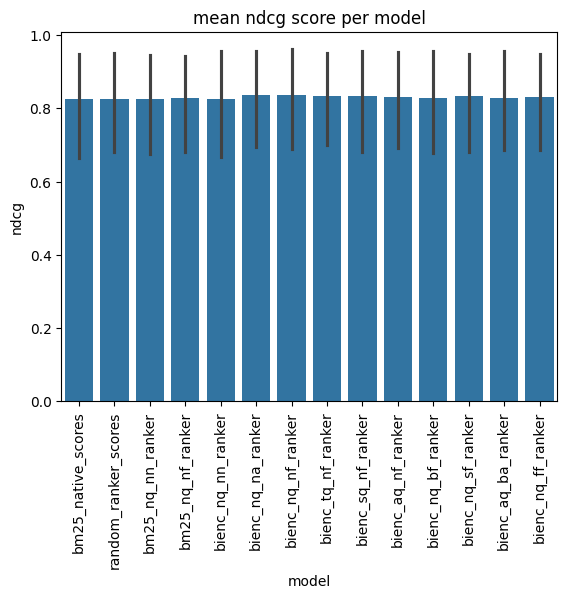

In [133]:
ax = sns.barplot(data=df, x="model", y="ndcg", estimator=np.mean)
plt.xticks(rotation=90)
ax.set_title('mean ndcg score per model');